In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [6]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [7]:
output_size = y_table.shape[0]

In [8]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
input_shape = x_test_2d_norm[0].shape

In [10]:
def build_2d_cnn_only_conv_ch_32_DO(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer

    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=32*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
#         x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
  
    x = Dropout(0.5)(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [11]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_32_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 253, 95, 32)       832       
_________________________________________________________________
activation (Activation)      (None, 253, 95, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 48, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 195072)            0         
_________________________________________________________________
dropout (Dropout)    

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.5280 - acc: 0.5413
Epoch 00001: val_loss improved from inf to 1.28709, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_1_conv_DO_checkpoint/001-1.2871.hdf5
36805/36805 [==============================] - 18s 479us/sample - loss: 1.5275 - acc: 0.5414 - val_loss: 1.2871 - val_acc: 0.6364
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.1168 - acc: 0.6653
Epoch 00002: val_loss improved from 1.28709 to 1.16840, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_1_conv_DO_checkpoint/002-1.1684.hdf5
36805/36805 [==============================] - 17s 457us/sample - loss: 1.1170 - acc: 0.6653 - val_loss: 1.1684 - val_acc: 0.6862
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9318 - acc: 0.7155
Epoch 00003: val_loss improved from 1.16840 to 1.09322, savin

Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1946 - acc: 0.9423
Epoch 00027: val_loss did not improve from 1.03689
36805/36805 [==============================] - 15s 398us/sample - loss: 0.1947 - acc: 0.9423 - val_loss: 1.2765 - val_acc: 0.7524
Epoch 28/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.1897 - acc: 0.9446
Epoch 00028: val_loss did not improve from 1.03689
36805/36805 [==============================] - 15s 397us/sample - loss: 0.1895 - acc: 0.9446 - val_loss: 1.2789 - val_acc: 0.7533
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1900 - acc: 0.9434
Epoch 00029: val_loss did not improve from 1.03689
36805/36805 [==============================] - 15s 410us/sample - loss: 0.1900 - acc: 0.9434 - val_loss: 1.3021 - val_acc: 0.7503
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1810 - acc: 0.9457
Epoch 00030: val_loss did not improve from 1.03689
36805/36805 [=====

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1043 - acc: 0.9701
Epoch 00057: val_loss did not improve from 1.03689
36805/36805 [==============================] - 15s 398us/sample - loss: 0.1043 - acc: 0.9701 - val_loss: 1.5797 - val_acc: 0.7461

2D_CNN_only_conv_ch_32_1_conv_DO Model


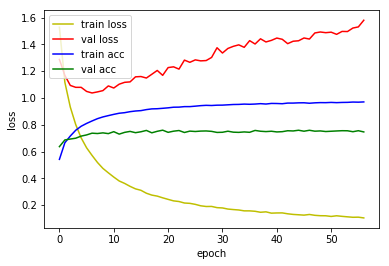

4815/4815 [==============================] - 1s 263us/sample - loss: 1.1518 - acc: 0.6984
Loss: 1.1517724619228644 Accuracy: 0.69844234

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5411 - acc: 0.5315
Epoch 00001: val_loss improved from inf to 1.10267, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_2_conv_DO_checkpoint/001-1.1027.hdf5
36805/36805 [==============================] - 18s 482us/sample - loss: 1.5410 - acc: 0.5316 - val_loss: 1.1027 - val_acc: 0.6983
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9679 - acc: 0.7134
Epoch 00002: val_loss improved from 1.10267 to 0.80992, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_2_conv_DO_checkpoint/002-0.8099.hdf5
36805/36805 [==============================] - 17s 461us/sample - loss: 0.9678 - acc: 0.7134 - val_loss: 0.8099 - val_acc: 0.7850
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.1106 - acc: 0.9658
Epoch 00026: val_loss did not improve from 0.46346
36805/36805 [==============================] - 17s 461us/sample - loss: 0.1106 - acc: 0.9658 - val_loss: 0.5036 - val_acc: 0.8998
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1040 - acc: 0.9669
Epoch 00027: val_loss did not improve from 0.46346
36805/36805 [==============================] - 17s 461us/sample - loss: 0.1040 - acc: 0.9669 - val_loss: 0.4900 - val_acc: 0.9012
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0982 - acc: 0.9700
Epoch 00028: val_loss did not improve from 0.46346
36805/36805 [==============================] - 17s 463us/sample - loss: 0.0982 - acc: 0.9700 - val_loss: 0.5032 - val_acc: 0.9024
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0966 - acc: 0.9687
Epoch 00029: val_loss did not improve from 0.46346
36805/36805 [==================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9868
Epoch 00056: val_loss did not improve from 0.46346
36805/36805 [==============================] - 17s 462us/sample - loss: 0.0460 - acc: 0.9868 - val_loss: 0.5600 - val_acc: 0.9096
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.9853
Epoch 00057: val_loss did not improve from 0.46346
36805/36805 [==============================] - 17s 459us/sample - loss: 0.0481 - acc: 0.9853 - val_loss: 0.5442 - val_acc: 0.9110
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9873
Epoch 00058: val_loss did not improve from 0.46346
36805/36805 [==============================] - 17s 461us/sample - loss: 0.0454 - acc: 0.9873 - val_loss: 0.5680 - val_acc: 0.9050
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9866
Epoch 00059: val_loss did not improve from 0.46346
36805/36805 [=====

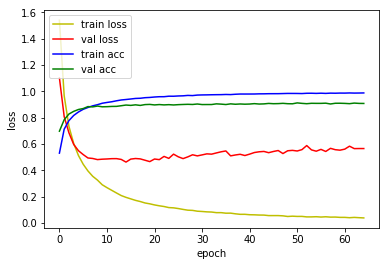

4815/4815 [==============================] - 1s 281us/sample - loss: 0.5462 - acc: 0.8652
Loss: 0.5462203813985624 Accuracy: 0.86521286

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6234 - acc: 0.4967
Epoch 00001: val_loss improved from inf to 1.07348, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_3_conv_DO_checkpoint/001-1.0735.hdf5
36805/36805 [==============================] - 19s 526us/sample - loss: 1.6234 - acc: 0.4967 - val_loss: 1.0735 - val_acc: 0.6969
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9384 - acc: 0.7175
Epoch 00002: val_loss improved from 1.07348 to 0.66269, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_3_conv_DO_checkpoint/002-0.6627.hdf5
36805/36805 [==============================] - 19s 504us/sample - loss: 0.9384 - acc: 0.7175 - val_loss: 0.6627 - val_acc: 0.8227
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0964 - acc: 0.9691
Epoch 00025: val_loss did not improve from 0.24074
36805/36805 [==============================] - 18s 493us/sample - loss: 0.0964 - acc: 0.9691 - val_loss: 0.2493 - val_acc: 0.9446
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0961 - acc: 0.9696
Epoch 00026: val_loss did not improve from 0.24074
36805/36805 [==============================] - 19s 511us/sample - loss: 0.0960 - acc: 0.9696 - val_loss: 0.2431 - val_acc: 0.9464
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0863 - acc: 0.9724
Epoch 00027: val_loss did not improve from 0.24074
36805/36805 [==============================] - 19s 513us/sample - loss: 0.0862 - acc: 0.9724 - val_loss: 0.2455 - val_acc: 0.9499
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0831 - acc: 0.9732
Epoch 00028: val_loss did not improve from 0.24074
36805/36805 [=====

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0430 - acc: 0.9860
Epoch 00055: val_loss did not improve from 0.24074
36805/36805 [==============================] - 19s 513us/sample - loss: 0.0430 - acc: 0.9860 - val_loss: 0.2759 - val_acc: 0.9481
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9865
Epoch 00056: val_loss did not improve from 0.24074
36805/36805 [==============================] - 18s 498us/sample - loss: 0.0440 - acc: 0.9866 - val_loss: 0.2801 - val_acc: 0.9497
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0426 - acc: 0.9871
Epoch 00057: val_loss did not improve from 0.24074
36805/36805 [==============================] - 18s 501us/sample - loss: 0.0426 - acc: 0.9871 - val_loss: 0.2710 - val_acc: 0.9509
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9871
Epoch 00058: val_loss did not improve from 0.24074
36805/36805 [=====

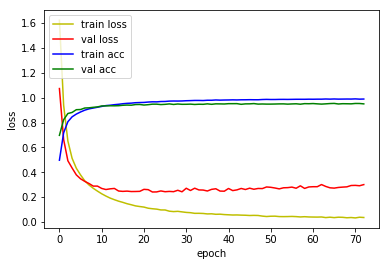

4815/4815 [==============================] - 1s 284us/sample - loss: 0.3144 - acc: 0.9200
Loss: 0.31443020229770385 Accuracy: 0.92004156

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8521 - acc: 0.4076
Epoch 00001: val_loss improved from inf to 1.07134, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_4_conv_DO_checkpoint/001-1.0713.hdf5
36805/36805 [==============================] - 21s 567us/sample - loss: 1.8520 - acc: 0.4076 - val_loss: 1.0713 - val_acc: 0.6890
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0546 - acc: 0.6673
Epoch 00002: val_loss improved from 1.07134 to 0.64835, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_4_conv_DO_checkpoint/002-0.6483.hdf5
36805/36805 [==============================] - 19s 526us/sample - loss: 1.0546 - acc: 0.6673 - val_loss: 0.6483 - val_acc: 0.8225
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1590 - acc: 0.9473
Epoch 00024: val_loss did not improve from 0.17048
36805/36805 [==============================] - 19s 527us/sample - loss: 0.1590 - acc: 0.9473 - val_loss: 0.1838 - val_acc: 0.9532
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1549 - acc: 0.9502
Epoch 00025: val_loss improved from 0.17048 to 0.16872, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_4_conv_DO_checkpoint/025-0.1687.hdf5
36805/36805 [==============================] - 19s 527us/sample - loss: 0.1549 - acc: 0.9502 - val_loss: 0.1687 - val_acc: 0.9550
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1464 - acc: 0.9532
Epoch 00026: val_loss improved from 0.16872 to 0.16525, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_4_conv_DO_checkpoint/026-0.1653.hdf5
36805/36805 [==============================] - 19s 527us/sample - loss: 0.1464 - acc: 0.9532 - val_l

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0759 - acc: 0.9744
Epoch 00051: val_loss did not improve from 0.15141
36805/36805 [==============================] - 20s 530us/sample - loss: 0.0759 - acc: 0.9744 - val_loss: 0.1655 - val_acc: 0.9634
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0739 - acc: 0.9753
Epoch 00052: val_loss did not improve from 0.15141
36805/36805 [==============================] - 20s 531us/sample - loss: 0.0739 - acc: 0.9753 - val_loss: 0.1638 - val_acc: 0.9630
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0774 - acc: 0.9755
Epoch 00053: val_loss did not improve from 0.15141
36805/36805 [==============================] - 19s 529us/sample - loss: 0.0774 - acc: 0.9755 - val_loss: 0.1736 - val_acc: 0.9623
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0736 - acc: 0.9756
Epoch 00054: val_loss did not improve from 0.15141
36805/36805 [=====

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9836
Epoch 00081: val_loss did not improve from 0.15141
36805/36805 [==============================] - 19s 529us/sample - loss: 0.0476 - acc: 0.9836 - val_loss: 0.1856 - val_acc: 0.9630
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0504 - acc: 0.9840
Epoch 00082: val_loss did not improve from 0.15141
36805/36805 [==============================] - 20s 531us/sample - loss: 0.0504 - acc: 0.9840 - val_loss: 0.1758 - val_acc: 0.9611
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9841
Epoch 00083: val_loss did not improve from 0.15141
36805/36805 [==============================] - 19s 528us/sample - loss: 0.0479 - acc: 0.9841 - val_loss: 0.1865 - val_acc: 0.9627
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9839
Epoch 00084: val_loss did not improve from 0.15141
36805/36805 [=====

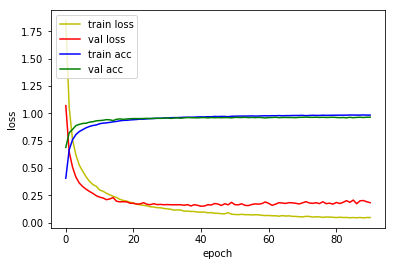

4815/4815 [==============================] - 1s 309us/sample - loss: 0.2294 - acc: 0.9371
Loss: 0.22936627486351246 Accuracy: 0.9370716



In [12]:
for i in range(1, 5):
    model_name = '2D_CNN_only_conv_ch_32_{}_conv_DO'.format(i)
    model = build_2d_cnn_only_conv_ch_32_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [13]:
for i in range(1, 5):
    model_name = '2D_CNN_only_conv_ch_32_{}_conv_DO'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


2D_CNN_only_conv_ch_32_1_conv_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 253, 95, 32)       832       
_________________________________________________________________
activation_10 (Activation)   (None, 253, 95, 32)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 48, 32)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 195072)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 195072)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 

In [14]:
def build_2d_cnn_only_conv_ch_32_BN(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer
    
    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=32*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
    x = BatchNormalization()(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [15]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_32_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 253, 95, 32)       832       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 253, 95, 32)       128       
_________________________________________________________________
activation_20 (Activation)   (None, 253, 95, 32)       0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 127, 48, 32)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 195072)            0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 195072)            780288    
__________

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1280 - acc: 0.5424
Epoch 00001: val_loss improved from inf to 1.66380, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_1_conv_BN_checkpoint/001-1.6638.hdf5
36805/36805 [==============================] - 25s 688us/sample - loss: 2.1282 - acc: 0.5424 - val_loss: 1.6638 - val_acc: 0.6003
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8888 - acc: 0.7742
Epoch 00002: val_loss improved from 1.66380 to 1.62216, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_1_conv_BN_checkpoint/002-1.6222.hdf5
36805/36805 [==============================] - 23s 615us/sample - loss: 0.8888 - acc: 0.7742 - val_loss: 1.6222 - val_acc: 0.6541
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4998 - acc: 0.8662
Epoch 00003: val_loss improved from 1.62216 to 1.58567, saving model to model/checkpoint/2D_CNN_only_conv_ch_

36800/36805 [============================>.] - ETA: 0s - loss: 0.0771 - acc: 0.9838
Epoch 00029: val_loss did not improve from 1.58567
36805/36805 [==============================] - 23s 616us/sample - loss: 0.0774 - acc: 0.9838 - val_loss: 2.6637 - val_acc: 0.6739
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0758 - acc: 0.9838
Epoch 00030: val_loss did not improve from 1.58567
36805/36805 [==============================] - 23s 616us/sample - loss: 0.0760 - acc: 0.9838 - val_loss: 2.6516 - val_acc: 0.6816
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0761 - acc: 0.9839
Epoch 00031: val_loss did not improve from 1.58567
36805/36805 [==============================] - 23s 615us/sample - loss: 0.0761 - acc: 0.9839 - val_loss: 2.7145 - val_acc: 0.6746
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0548 - acc: 0.9894
Epoch 00032: val_loss did not improve from 1.58567
36805/36805 [==================

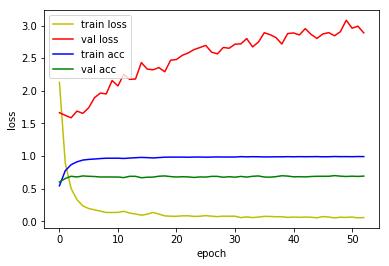

4815/4815 [==============================] - 2s 325us/sample - loss: 1.7279 - acc: 0.6534
Loss: 1.7279256380235666 Accuracy: 0.65337485

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4233 - acc: 0.5970
Epoch 00001: val_loss improved from inf to 1.05937, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_2_conv_BN_checkpoint/001-1.0594.hdf5
36805/36805 [==============================] - 29s 787us/sample - loss: 1.4234 - acc: 0.5970 - val_loss: 1.0594 - val_acc: 0.7063
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6833 - acc: 0.8029
Epoch 00002: val_loss improved from 1.05937 to 0.80164, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_2_conv_BN_checkpoint/002-0.8016.hdf5
36805/36805 [==============================] - 25s 681us/sample - loss: 0.6835 - acc: 0.8028 - val_loss: 0.8016 - val_acc: 0.7794
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0156 - acc: 0.9969
Epoch 00028: val_loss did not improve from 0.63177
36805/36805 [==============================] - 25s 680us/sample - loss: 0.0156 - acc: 0.9969 - val_loss: 0.8511 - val_acc: 0.8463
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9969
Epoch 00029: val_loss did not improve from 0.63177
36805/36805 [==============================] - 25s 681us/sample - loss: 0.0153 - acc: 0.9968 - val_loss: 0.8373 - val_acc: 0.8428
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0341 - acc: 0.9908
Epoch 00030: val_loss did not improve from 0.63177
36805/36805 [==============================] - 25s 680us/sample - loss: 0.0341 - acc: 0.9908 - val_loss: 0.8552 - val_acc: 0.8465
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0162 - acc: 0.9971
Epoch 00031: val_loss did not improve from 0.63177
36805/36805 [=====

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0060 - acc: 0.9990
Epoch 00058: val_loss did not improve from 0.63177
36805/36805 [==============================] - 25s 680us/sample - loss: 0.0061 - acc: 0.9990 - val_loss: 0.9613 - val_acc: 0.8486
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0109 - acc: 0.9978
Epoch 00059: val_loss did not improve from 0.63177
36805/36805 [==============================] - 25s 679us/sample - loss: 0.0109 - acc: 0.9978 - val_loss: 0.8730 - val_acc: 0.8602

2D_CNN_only_conv_ch_32_2_conv_BN Model


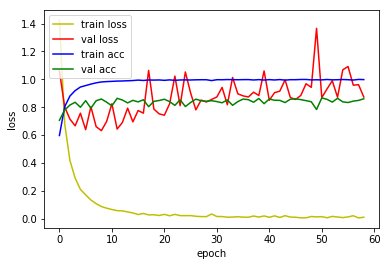

4815/4815 [==============================] - 2s 352us/sample - loss: 0.7404 - acc: 0.8237
Loss: 0.7404076204988196 Accuracy: 0.823676

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3933 - acc: 0.5851
Epoch 00001: val_loss improved from inf to 0.99236, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_3_conv_BN_checkpoint/001-0.9924.hdf5
36805/36805 [==============================] - 33s 889us/sample - loss: 1.3934 - acc: 0.5851 - val_loss: 0.9924 - val_acc: 0.7091
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6985 - acc: 0.7942
Epoch 00002: val_loss improved from 0.99236 to 0.62002, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_3_conv_BN_checkpoint/002-0.6200.hdf5
36805/36805 [==============================] - 27s 744us/sample - loss: 0.6980 - acc: 0.7943 - val_loss: 0.6200 - val_acc: 0.8311
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

36736/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9956
Epoch 00026: val_loss did not improve from 0.34137
36805/36805 [==============================] - 27s 738us/sample - loss: 0.0232 - acc: 0.9956 - val_loss: 0.3694 - val_acc: 0.9217
Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9944
Epoch 00027: val_loss did not improve from 0.34137
36805/36805 [==============================] - 27s 743us/sample - loss: 0.0255 - acc: 0.9943 - val_loss: 0.3708 - val_acc: 0.9178
Epoch 28/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9943
Epoch 00028: val_loss did not improve from 0.34137
36805/36805 [==============================] - 27s 741us/sample - loss: 0.0251 - acc: 0.9943 - val_loss: 0.5992 - val_acc: 0.8668
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0197 - acc: 0.9964
Epoch 00029: val_loss did not improve from 0.34137
36805/36805 [==================

Epoch 56/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9984
Epoch 00056: val_loss did not improve from 0.34137
36805/36805 [==============================] - 28s 765us/sample - loss: 0.0077 - acc: 0.9984 - val_loss: 0.3930 - val_acc: 0.9248
Epoch 57/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9990
Epoch 00057: val_loss did not improve from 0.34137
36805/36805 [==============================] - 28s 763us/sample - loss: 0.0061 - acc: 0.9989 - val_loss: 0.3928 - val_acc: 0.9255
Epoch 58/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0211 - acc: 0.9942
Epoch 00058: val_loss did not improve from 0.34137
36805/36805 [==============================] - 28s 761us/sample - loss: 0.0211 - acc: 0.9942 - val_loss: 0.3970 - val_acc: 0.9250
Epoch 59/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9986
Epoch 00059: val_loss did not improve from 0.34137
36805/36805 [=====

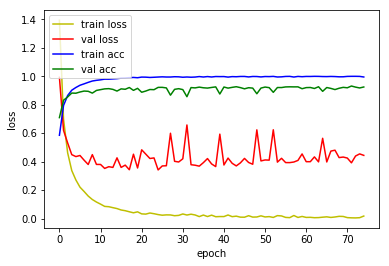

4815/4815 [==============================] - 2s 399us/sample - loss: 0.4188 - acc: 0.8957
Loss: 0.41879333938517427 Accuracy: 0.8957425

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6059 - acc: 0.5083
Epoch 00001: val_loss improved from inf to 1.03461, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_4_conv_BN_checkpoint/001-1.0346.hdf5
36805/36805 [==============================] - 36s 985us/sample - loss: 1.6058 - acc: 0.5083 - val_loss: 1.0346 - val_acc: 0.6937
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.8128 - acc: 0.7598
Epoch 00002: val_loss improved from 1.03461 to 0.61051, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_4_conv_BN_checkpoint/002-0.6105.hdf5
36805/36805 [==============================] - 29s 787us/sample - loss: 0.8129 - acc: 0.7598 - val_loss: 0.6105 - val_acc: 0.8332
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s -

36736/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9874
Epoch 00025: val_loss did not improve from 0.21109
36805/36805 [==============================] - 29s 783us/sample - loss: 0.0519 - acc: 0.9873 - val_loss: 0.2541 - val_acc: 0.9327
Epoch 26/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.9876
Epoch 00026: val_loss did not improve from 0.21109
36805/36805 [==============================] - 29s 788us/sample - loss: 0.0518 - acc: 0.9875 - val_loss: 0.2408 - val_acc: 0.9355
Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9892
Epoch 00027: val_loss did not improve from 0.21109
36805/36805 [==============================] - 29s 783us/sample - loss: 0.0475 - acc: 0.9892 - val_loss: 0.2589 - val_acc: 0.9338
Epoch 28/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0395 - acc: 0.9911
Epoch 00028: val_loss did not improve from 0.21109
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9944
Epoch 00054: val_loss did not improve from 0.20000
36805/36805 [==============================] - 29s 786us/sample - loss: 0.0234 - acc: 0.9944 - val_loss: 0.2336 - val_acc: 0.9427
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9980
Epoch 00055: val_loss did not improve from 0.20000
36805/36805 [==============================] - 29s 782us/sample - loss: 0.0113 - acc: 0.9979 - val_loss: 0.2325 - val_acc: 0.9422
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9960
Epoch 00056: val_loss did not improve from 0.20000
36805/36805 [==============================] - 29s 784us/sample - loss: 0.0174 - acc: 0.9960 - val_loss: 0.2245 - val_acc: 0.9453
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0123 - acc: 0.9974
Epoch 00057: val_loss did not improve from 0.20000
36805/36805 [==================

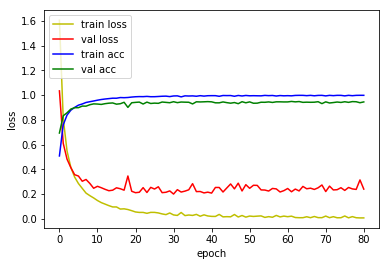

4815/4815 [==============================] - 2s 410us/sample - loss: 0.2785 - acc: 0.9238
Loss: 0.27846501246172073 Accuracy: 0.92377985



In [16]:
for i in range(1, 5):
    model_name = '2D_CNN_only_conv_ch_32_{}_conv_BN'.format(i)
    model = build_2d_cnn_only_conv_ch_32_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [17]:
for i in range(1, 5):
    model_name = '2D_CNN_only_conv_ch_32_{}_conv_BN'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


2D_CNN_only_conv_ch_32_1_conv_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 253, 95, 32)       832       
_________________________________________________________________
batch_normalization_v1_14 (B (None, 253, 95, 32)       128       
_________________________________________________________________
activation_30 (Activation)   (None, 253, 95, 32)       0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 127, 48, 32)       0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 195072)            0         
_________________________________________________________________
batch_normalization_v1_15 (B (None, 

4815/4815 [==============================] - 2s 453us/sample - loss: 0.2785 - acc: 0.9238
Loss: 0.27846501246172073 Accuracy: 0.92377985


In [18]:
def build_2d_cnn_only_conv_ch_32_DO_BN(conv_num=1):
    input_layer = Input(shape=input_shape)
    x = input_layer
    
    for i in range(conv_num):
        x = Conv2D(kernel_size=5, filters=32*(2**int((i)/2)), strides=(1,1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=2, strides=(2,2), padding='same')(x)

    x = Flatten()(x)
  
    x = Dropout(0.5)(x)
    output_layer = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [ ]:
for i in range(1, 5):
    model = build_2d_cnn_only_conv_ch_32_DO_BN(conv_num=i)
    model.summary()
    del model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 257, 99, 1)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 253, 95, 32)       832       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 253, 95, 32)       128       
_________________________________________________________________
activation_40 (Activation)   (None, 253, 95, 32)       0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 127, 48, 32)       0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 195072)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 195072)            0         
__________

In [ ]:
for i in range(1, 5):
    model_name = '2D_CNN_only_conv_ch_32_{}_conv_DO_BN'.format(i)
    model = build_2d_cnn_only_conv_ch_32_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0427 - acc: 0.4815
Epoch 00001: val_loss improved from inf to 1.86061, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_1_conv_DO_BN_checkpoint/001-1.8606.hdf5
36805/36805 [==============================] - 28s 771us/sample - loss: 2.0427 - acc: 0.4815 - val_loss: 1.8606 - val_acc: 0.5094
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4420 - acc: 0.6149
Epoch 00002: val_loss improved from 1.86061 to 1.39277, saving model to model/checkpoint/2D_CNN_only_conv_ch_32_1_conv_DO_BN_checkpoint/002-1.3928.hdf5
36805/36805 [==============================] - 22s 600us/sample - loss: 1.4422 - acc: 0.6149 - val_loss: 1.3928 - val_acc: 0.6320
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1678 - acc: 0.6735
Epoch 00003: val_loss did not improve from 1.39277
36805/36805 [==============================] - 22s 6

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2575 - acc: 0.9242
Epoch 00029: val_loss did not improve from 1.30650
36805/36805 [==============================] - 22s 600us/sample - loss: 0.2575 - acc: 0.9242 - val_loss: 1.7019 - val_acc: 0.7258
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2401 - acc: 0.9284
Epoch 00030: val_loss did not improve from 1.30650
36805/36805 [==============================] - 22s 601us/sample - loss: 0.2401 - acc: 0.9284 - val_loss: 1.7302 - val_acc: 0.7317
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2326 - acc: 0.9332
Epoch 00031: val_loss did not improve from 1.30650
36805/36805 [==============================] - 22s 597us/sample - loss: 0.2327 - acc: 0.9332 - val_loss: 1.7539 - val_acc: 0.7237
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2344 - acc: 0.9309
Epoch 00032: val_loss did not improve from 1.30650
36805/36805 [=====

In [ ]:
for i in range(1, 5):
    model_name = '2D_CNN_only_conv_ch_32_{}_conv_BN'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)